In [1]:
import axs
from axs import Constants

import axs
import numpy as np
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
from astropy.coordinates import SkyCoord
import scipy.stats as sci_stat 

import pandas as pd
import matplotlib.pyplot as plt

from astropy.io import ascii
import pandas as pd
from astropy.table import Table
import os
from tqdm import tqdm
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from tqdm import tqdm
import pandas as pd

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20

In [2]:
def spark_start(local_dir):
    from pyspark.sql import SparkSession
    
    spark = (
            SparkSession.builder
            .appName("LSD2")
            .config("spark.sql.warehouse.dir", local_dir)
            .config('spark.master', "local[10]") # num workers
            .config('spark.driver.memory', '90G') # 128
            .config('spark.local.dir', local_dir)
            .config('spark.memory.offHeap.enabled', 'true')
            .config('spark.memory.offHeap.size', '180G') # 256
            .config("spark.sql.execution.arrow.enabled", "true")
            .config("spark.driver.maxResultSize", "25G")
            .config("spark.driver.extraJavaOptions", f"-Dderby.system.home={local_dir}")
            .enableHiveSupport()
            .getOrCreate()
                    )   

    return spark

spark_session = spark_start("/epyc/users/atzanida/spark-tmp/")

catalog = axs.AxsCatalog(spark_session)

In [3]:
spark_session

In [4]:
# Declare catalog names
gaia_name = "gaia_dr3_source" # Gaia DR3
ztf_name = "ztf_dr14" # ZTF DR14

# Load catalogs
gr3 = catalog.load(gaia_name)
ztf = catalog.load(ztf_name)

In [5]:
# match
match = gr3.crossmatch(ztf)

In [6]:
match_final = match.where((match['teff_gspphot']>=5_380) & # limit on G0 dwarfs
                      (match['teff_gspphot']<=7_220) & # limit on F9 dwarfs
                      (match['logg_gspphot']>=4.5) &
                      (match['logg_gspphot']<=4.72) & 
                      (match['classprob_dsc_combmod_star']>0.5) & # >50% it's a star
                      (match['parallax_over_error'] >= 5) &  # high SNR parallaxes & 
                      (match['nobs_r']>100) & (match['nobs_g']>100))

In [7]:
mm = match_final.select("ra", "dec", "pmra", 
              'pmdec', 'parallax', 'parallax_over_error', 
              'phot_g_mean_mag', 'bp_rp', 'source_id',
              'teff_gspphot', 'logg_gspphot', 
              'ag_gspphot',
              'nobs_r', 'nobs_g', 
              'mjd_r', 'mjd_g', 
              'mag_r', 'mag_g', 
              'magerr_r', 'magerr_g', 
            "catflags_r", "catflags_g", 
                     "mean_mag_r", "mean_mag_g")

In [ ]:
%%time
mm.write.parquet("data/ZTFGaia_FGdwarfs_final_query.parquet")

In [28]:
%%time
_table = pd.read_parquet("data/ZTFGaia_Fdwarfs_query.parquet")

CPU times: user 41.7 s, sys: 31.5 s, total: 1min 13s
Wall time: 46 s


Text(0, 0.5, 'Number')

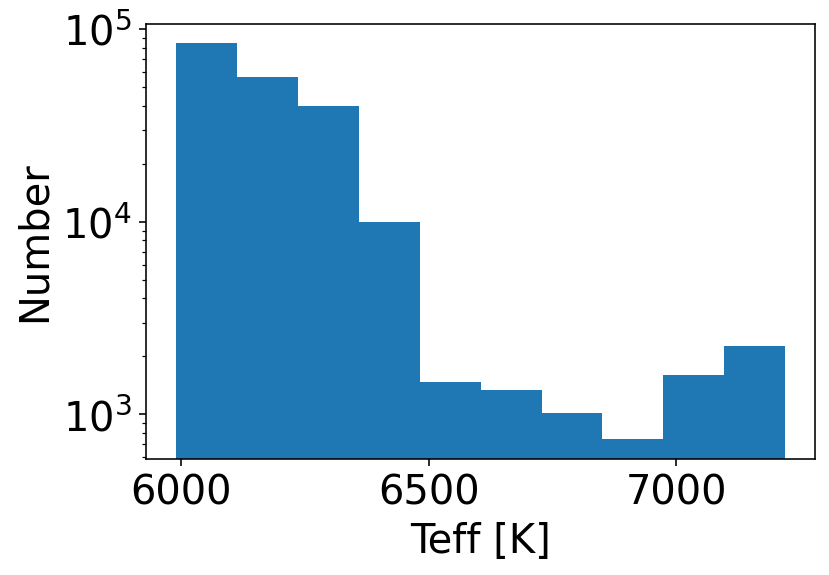

In [40]:
_ = plt.hist(_table['teff_gspphot'])
plt.yscale('log')
plt.xlabel("Teff [K]")
plt.ylabel("Number")

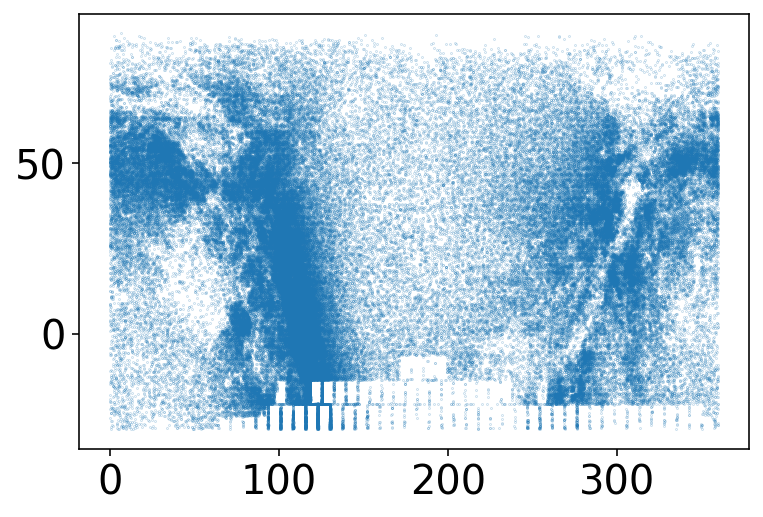

In [34]:
plt.scatter(_table['ra'], _table['dec'], s=0.01)

In [35]:
len(_table)

199183

(19.354706150000002, 11.538960849999999)

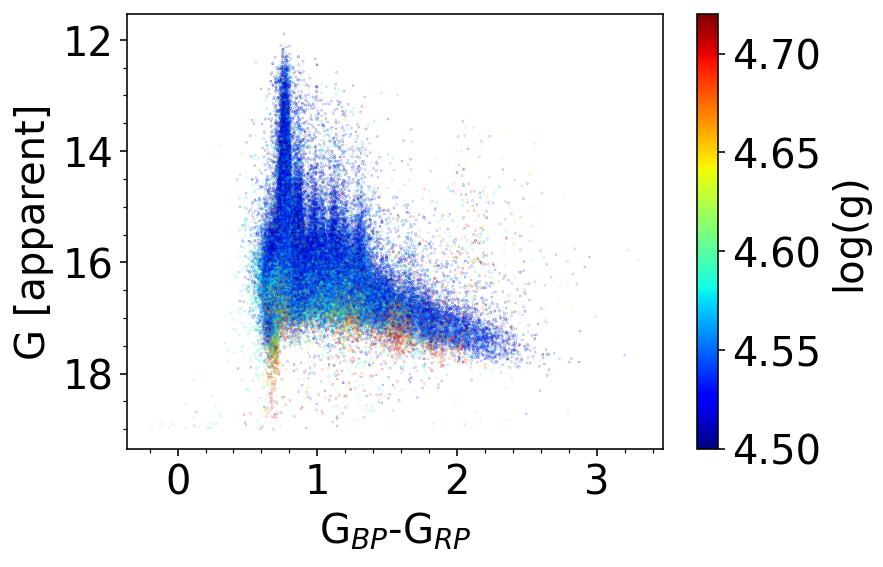

In [50]:
plt.scatter(_table['bp_rp'], _table['phot_g_mean_mag'], s=0.01, c=_table['logg_gspphot'], 
           cmap='jet')
plt.colorbar(label='log(g)')
plt.xlabel("G$_{BP}$-G$_{RP}$")
plt.ylabel("G")
plt.minorticks_on()
plt.ylim(plt.ylim()[::-1])